In [1]:
import numpy as np
import scipy.ndimage as ndi
from skimage import measure,color,exposure
import matplotlib.pyplot as plt
import cv2

In [2]:
from skimage import io
import skimage.external.tifffile as tif
image = tif.imread('../benchdata/1.tif')
#size:574,760,3
# tif.imshow(image,cmap='gray')
# print(image[0][0][0])
# print(image.min(),image.max())

(574, 760) 0.7960784313725491


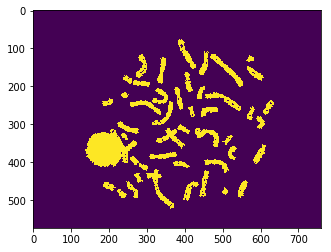

In [3]:
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.color import rgb2gray
from skimage import morphology
grayscale = rgb2gray(image)
print(grayscale.shape,grayscale[0][0])
# global_thresh = threshold_otsu(grayscale)
better_contrast = exposure.rescale_intensity(grayscale)
global_thresh = threshold_otsu(better_contrast)
binary_global = better_contrast < global_thresh
# block_size = 19
# binary_adaptive = ~threshold_adaptive(grayscale, block_size, offset=0.01)
# binary_adaptive=morphology.remove_small_objects(binary_adaptive,min_size=35,connectivity=1)
# fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(18,9))
binary_global=morphology.remove_small_objects(binary_global,min_size=35,connectivity=1)
plt.imshow(binary_global)

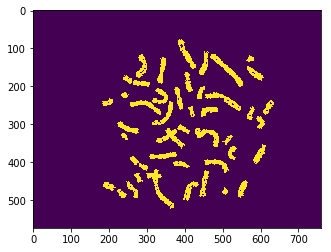

In [4]:
from skimage import morphology
out=binary_global.copy()
if out.dtype == bool:
    selem = ndi.generate_binary_structure(binary_global.ndim,1)
    ccs = np.zeros_like(binary_global, dtype=np.int32)
    ndi.label(binary_global, selem, output=ccs)
else:
    ccs = out
component_sizes = np.bincount(ccs.ravel())
#removes the interphase nuclei (e.g., the size >1000 pixels and the circularity >0.8)
too_big = component_sizes > 6000
too_big_mask = too_big[ccs]
out[too_big_mask] = 0
plt.imshow(out)

regions number: 43


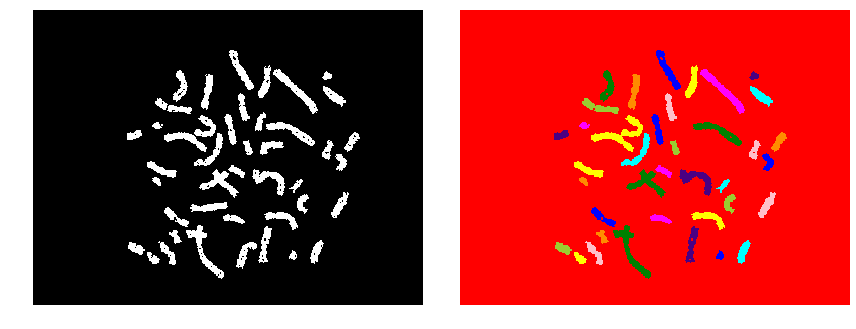

In [5]:
from skimage.morphology import closing, square
outc= closing(out, square(3))
labels=measure.label(outc,connectivity=2)
dst=color.label2rgb(labels)  #根据不同的标记显示不同的颜色
print('regions number:',labels.max()+1)  #显示连通区域块数(从0开始标记)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(out, plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dst,interpolation='nearest')
ax2.axis('off')
fig.tight_layout()
plt.show()

In [6]:
from skimage.measure import label, regionprops
regions = regionprops(labels)
count=1
#crop chromosomes from the raw image
for props in regions:
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    signal=str(count)+".png"
    count+=1
    io.imsave("../bench_segment/"+signal,image[minr:maxr,minc:maxc])

/home/hywang/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))
